# 4.1 Landmark-based models

In order to carry out tasks like localization or navigation, a mobile robot has to perceive its workspace. A variety of sensors can be used for that, as well as a number of probabilistic models for managing their behavior.

Typically, the sensors used onboard the robot do not deliver the exact truth of the quantities they are measuring, but a perturbed version. This is due to the working (physical) principles that govern the sensors behavior, and to the conditions of their workspaces (illumination, humidity, temperature, etc.). 

As an illustrative example of this, there is a popular European company called [Sick](https://www.sick.com/es/es/), which develops 2D LiDAR sensors (among other devices). One of its most popular sensors is the [TiM2xx one](https://www.sick.com/gb/en/detection-and-ranging-solutions/2d-lidar-sensors/tim2xx/tim240-2050300/p/p654443) (see left part of Fig.1), which can be easily integrable into a robotic platform. If we take a look at the specifications about the performance of such device, we can check how this uncertainty about the sensor measurements is explicitly specified (systematic error and statistical error), as well as how these values depend on environmental conditions (see right part of Fig.1). $\\[10pt]$

<figure style="text-align:center">
  <img src="images/sick-laser.PNG" alt="">
  <figcaption>Fig. 1: Left, TiM2xx sensor from Sick. Right, performance details of such sensor.</figcaption>
</figure>    

$\\[5pt]$To account for this behavior, sensors' measurements in probabilistic robotics will be modeled by... wait for it... the probability distribution $p(z|v)$, where z models the measurement and v is the ground truth.

## 4.1.1 Dealing with landmark-based models

In different applications it is interesting for the robot to detect landmarks in its workspace and build internal representations of them, commonly referred to as maps. In the case of maps consisting of a collection of landmarks $m=\{m_i\}, i=1,\dots,N$, different types of sensors can be used to provide observations $z_i$ of those landmarks:

- **Distance/range** (*e.g.* radio, GPS, etc.): $\\[2pt]$
  $\hspace{1cm}$ $z_i = d_i = h_i(x,m)+w_i$ $\\[2pt]$
- **Bearing** (*e.g.* camera): $\\[2pt]$
  $\hspace{1cm}$$z_i = \theta_i = h_i(x,m)+w_i$ $\\[2pt]$
- **Distance/range and bearing** (*e.g.* stereo, features in a scan, etc.) $\\[2pt]$
  $\hspace{1cm}$$z_i = [d_i,\theta_i]^T = h_i(x,m)+w_i$ *(in this case, $h_i(x,m)$ and $w_i$ are 2D vectors)* $\\[2pt]$

where:

- $z_i$ is an observation, $x$ is the sensor pose, and $m$ is the map of the environment,
- $h(x,m)$ is the Observation (or measurement, or prediction) function: it predicts the value of the observation $z_i$ given the state values $x$ and $m$, and
- $w$ is an error, modeled by a gaussian distribution as $w=[h(x,m)-z_i]\sim N(O,Q)$, being $Q$ the uncertainty in the observation error. 

In this way, the probability distribution $p(z|x,m)$ modeling the sensor measurements results:

$$
p(z|x,m) = K \exp\{-\frac{1}{2}[h(x,m)-z]^T Q^{-1} [h(x,m)-z]\}
$$

These types of maps and sensor measurements pose a new problem: **data association**, that is, with which landmark $m_i$ correspond the observation $z_i$ to: 

$$h_i(x,m)=h(x,m_i)$$

This problem is usually addressed by applying Chi-squared tests, although for the shake of simplicity in this book we will consider it as solved. 

### Playing with landmarks and robot poses

In the remaining of this section we will familiarize ourselves with the process of observing landmarks from robots located at certain poses, as well as the transformations needed to make use of these observations, that is, to express those observations into the world frame and backwards.

Some relevant concepts:

- **World frame**: $(x, y)$ coordinates from a selected point of reference $(0, 0)$ used to keep track of the robots pose and landmarks within the map.
- **Observation**: Information from the real world provided by a sensor, from the point of view (*pov*) of a certain robot.
- **Range-bearing sensor**: Sensor model being used in this lesson. This kind of sensors detect how far is an object $(d)$ and its orientation relative to the robot's one $(\theta)$.

The main tools to deal with those concepts are:

- the composition of two poses.
- the composition of a pose and a landmark.
- the propagation of uncertainty through the Jacobians of these compositions.

We will address several problems of incremental complexity. In all of them, it is important to have in mind how the composition of a (robot) pose and a landmark point works:


<center>
    <a id="figure"></a>
    <img src="images/fig4-1.png">
    <figcaption>Fig. 1: Composition of a pose and a landmark point.</figcaption>
</center>

In [1]:
#%matplotlib widget
%matplotlib inline

# IMPORTS

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import sys
sys.path.append("..")
from utils.PlotEllipse import PlotEllipse
from utils.DrawRobot import DrawRobot
from utils.tcomp import tcomp
from utils.tinv import tinv, jac_tinv1 as jac_tinv
from utils.Jacobians import J1, J2

### **<span style="color:green"><b><i>ASSIGNMENT 1: Expressing an observed landmark in coordinates of the world frame</i></b></span>** <a id="4211"></a> 

Let’s consider a robot R1 at a perfectly known pose $p_1 = [1, 2, 0.5]^T$ (no uncertainty at this point) which observes a landmark $m$ with a range-bearing (polar) sensor affected by a zero-mean Gaussian error with covariance $W_{1p} = diag\left([0.25, 0.04]\right)$. The sensor provides the measurement $z_{1p} = [4m., 0.7rad.]^T$. The scenario is the one in Fig. 2.

<center>
    <img src="./images/assignment_1.png"/>
    <figcaption>Fig 2. Illustration of the scenario in assignment 1.</figcaption>
</center>
 
**You are tasked to** compute the Gaussian probability distribution  (mean and covariance) of the landmark observation in the world frame (the same as the robot)  and plot its corresponding ellipse (in magenta, $\sigma=1$). Concretely, you have to complete the ``to_world_frame()`` function, and modify the demo code to show the ellipse representing the uncertainty. 
 
 Consider the following:
 
 - You can express a sensor measurement in polar coordinates ($z_p=[r,\alpha]^T$) as cartesian coordinates ($z_c=[z_x,z_y]^T)$ by:
 
 $$
     z_c = \begin{bmatrix} z_x \\ z_y \end{bmatrix} 
         = \begin{bmatrix} r \cos\alpha \\ r \sin\alpha \end{bmatrix} 
         = f(r,\alpha)
 $$ $\\[5pt]$
 
 - While computing the covariance of the landmark observation, you have to start by computing the covariance of the observation in the Cartesian robot $R1$ frame. That is:
 
 $$  
 W_{c} = \frac{\partial f(r,\alpha)}{\partial \{r,\alpha\}} \ W_{p} \ \frac{f(r,\alpha)}{\partial \{r,\alpha\}}^T
 $$
   
   Then you can get the convariance in the world frame as:
   
   $$ W_{z\_w} = \frac{\partial f(p,z_c)}{\partial p} \ Q_{p1\_w} \ \left( \frac{\partial f(p,z_c)}{\partial p} \right)^T +
        \frac{\partial f(p,z_c)}{\partial z_c} \ W_{c} \ \left( \frac{\partial f(p,z_c)}{\partial z_c} \right)^T
   $$
   
   where $f(p,z_c) = p \oplus z_c$, that is, the composition of the pose and the landmark.
   
   - Note that $\frac{\partial f(p,z_c)}{\partial p}$ and $\frac{\partial f(p,z_c)}{\partial z_c}$ are the same Jacobians as previously used to compose two poses in *robot motion*, but with a reduced size since **while working with landmarks the orientation is meaningless, only the position matters**. The functions ``J1()`` and ``J2()`` implement these jacobians for you. $\\[5pt]$
   
Example: $\\[5pt]$

<center>
    <img src="./images/result_1.png" />
    <figcaption>Fig 3. Pose of a robot (without uncertainty) and position of an observed landmark with its associated uncertainty.</figcaption>
</center>

In [15]:
def to_world_frame(p1_w, Qp1_w, z1_p_r, W1):
    """ Covert the observation z1_p_r to the world frame
    
        Args:
            p1_w: Pose of the robot(in world frame)
            Qp1_w: Covariance of the robot
            z1_p_r: Observation to a landmark (polar coordinates) from robots perspective
            W1: Covariance of the sensor in polar coordinates
    
        Returns:
            z1_w: Pose of landmark in the world frame
            Wz1: Covariance associated to z1_w
    """
    
    # Definition of useful variables
    r, a = z1_p_r[0,0], z1_p_r[1,0]
    s, c = np.sin(a), np.cos(a)

    # Jacobian to convert the measurement uncertainty from polar to cartesian coordinates
    Jac_pol_car = np.array([
        [c, -r*s],
        [s, r*c]
    ])

    # Built a tuple with:
    # z1_car_rel[0]: coordinates of the sensor measurement in cartesian coordinates relative to robot position
    # z1_car_rel[1]: its associated uncertainty expressed in cartesian coordinates
    z1_car_rel = (
            np.vstack([r*c, r*s]), # position
            Jac_pol_car@W1@Jac_pol_car.T # uncertainty
            )
    
    z1_ext = np.vstack([z1_car_rel[0], 0]) # Extends z1 for its usage in the Jacobian functions J1 and J2

    # Build the jacobians 
    Jac_ap = J1(p1_w, z1_ext)[0:2,:] # Jacobian for expressing the uncertainty in the robot pose in a global frame
    Jac_aa = J2(p1_w, z1_ext)[0:2,0:2] # This one expresses the uncertainty in the measurment in a global frame
    
    z1_w = tcomp(p1_w, z1_ext)[0:2,[0]] # Compute coordinates of the landmark in the world
    Wz1 = (Jac_ap @ Qp1_w @ Jac_ap.T
          + Jac_aa @ z1_car_rel[1] @ Jac_aa.T) # Finally, propagate the covariance!

    return z1_w, Wz1

----	Exercise 4.1.1	----
z1_w = [2.44943102 5.72815634]'
Wz1_w = 
[[ 0.58879177 -0.13171532]
 [-0.13171532  0.30120823]]



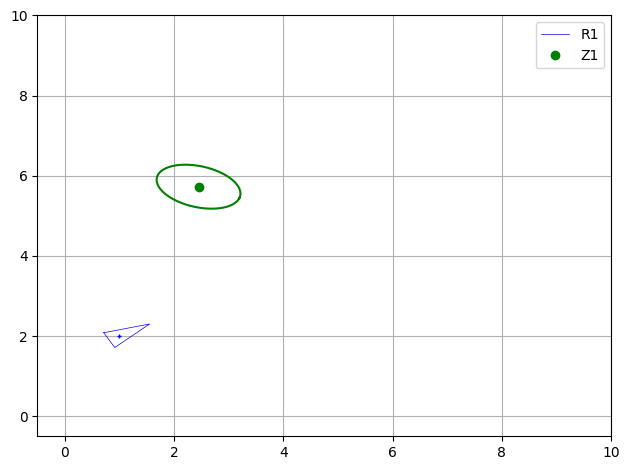

In [16]:
# Robot
p1_w = np.vstack([1, 2, 0.5]) # Robot R1 pose
Qp1_w = np.zeros((3, 3)) # Robot pose convariance matrix (uncertainty)

# Landmark observation
z1_p_r = np.vstack([4., .7]) # Measurement/Observation
W1 = np.diag([0.25, 0.04]) # Sensor noise covariance

# Express the landmark observation in the world frame (mean and covariance)
z1_w, Wz1 = to_world_frame(p1_w, Qp1_w, z1_p_r, W1)

# Visualize the results
fig, ax = plt.subplots()
plt.xlim([-.5, 10])
plt.ylim([-.5, 10])
plt.grid()
plt.tight_layout()

DrawRobot(fig, ax, p1_w, label='R1', color='blue')
    
ax.plot(z1_w[0, 0], z1_w[1, 0], 'o', label='Z1', color='green')
PlotEllipse(fig, ax, mean=z1_w, cov=Wz1, color='green')

plt.legend()
print('----\tExercise 4.1.1\t----\n'+
      'z1_w = {}\'\n'.format(z1_w.flatten())
      + 'Wz1_w = \n{}\n'.format(Wz1))

<span style="color:blue">Expected results for demo:</span>


```
---- Exercise 4.1.1 ----
z1_w = [2.44943102 5.72815634]'
Wz1_w = 
[[ 0.58879177 -0.13171532]
 [-0.13171532  0.30120823]]
```

### **<span style="color:green"><b><i>ASSIGNMENT 2: Adding uncertainty to the robot position</i></b></span>**

Now, let’s assume that the robot pose is not known, but it is a RV that follows a
Gaussian probability distribution: $p_1 \sim N([1, 2, 0.5]^T, \Sigma_1)$ with $\Sigma_1 = diag([0.08,0.6,
0.02 ])$.

1. Compute the covariance matrix $\Sigma_{m1}$ of the landmark in the world frame and plot it as an ellipse centered at the mean $m_1$ (in blue, $sigma= 1$). Plot also the covariance of the robot pose (in blue, $sigma= 1$).
     
2. Compare the covariance with that obtained in the previous case.  $\\[5pt]$
   
Example: $\\[5pt]$

<center>
    <img src="./images/result_2.png" />
    <figcaption>Fig 4. Pose of a robot and position of an observed landmark, along with their associated uncertainties.</figcaption>
</center>

In [ ]:
# Robot
p1_w = np.vstack([1, 2, 0.5]) # Robot R1 pose
Qp1_w = np.diag([0.08,0.6,0.02])  # Robot pose convariance matrix (uncertainty)

# Landmark observation
z1_p_r = np.vstack([4., .7]) # Measurement/Observation
W1 = np.diag([0.25, 0.04]) # Sensor noise covariance

# Express the landmark observation in the world frame (mean and covariance)
z1_w, Wz1 = to_world_frame(p1_w, Qp1_w, z1_p_r, W1)

# MATPLOTLIB
fig, ax = plt.subplots()
plt.xlim([-.5, 10])
plt.ylim([-.5, 10])
plt.grid()
plt.tight_layout()

fig.canvas.draw()

DrawRobot(fig, ax, p1_w, label='R1', color='red')  
PlotEllipse(fig, ax, mean=p1_w[0:1], cov=Qp1_w, color='blue')

ax.plot(z1_w[0, 0], z1_w[1, 0], 'o', label='Z1', color='green')
PlotEllipse(fig, ax, mean=z1_w, cov=Wz1, color='green')

plt.legend()
print('---- Exercise 4.1.2 ----\n'+
      'Wz1_w = \n{}\n'.format(Wz1))


<span style="color:blue">Expected results for demo:</span>

```
---- Exercise 4.1.2 ----
Wz1_w = 
[[ 0.94677477 -0.23978943]
 [-0.23978943  0.94322523]]
```

### **<span style="color:green"><b><i>ASSIGNMENT 3: Getting the relative pose between two robots</i></b></span>** 

Another robot `R2` is at pose $p_2 \sim ([6m., 4m., 2.1rad.]^T, \Sigma_2)$ with $\Sigma_2 = diag([0.20,0.09,
 0.03])$. Plot `p2` and its ellipse (covariance) in green ($sigma=1$). **Compute the relative pose `p12` between `R1` and `R2`**, including its associated uncertainty. This scenario is shown in Fig. 5.
 
<center>
    <img src="./images/assignment_3.png"/>
    <figcaption>Fig 5. Illustration of the scenario in this assignment.</figcaption>
</center>
 
 This relative pose can be obtained in two different ways:
 - **Through the composition of poses**, but using $\ominus p1$ instead of $p1$. Implement it in ``inverse_composition1()``.
 
 Mean: 
 
 $$
 p12 = \ominus p1 \oplus p2 = f(\ominus p1, p2) = 
 \begin{bmatrix} 
  x_{\ominus p1} + x_{p2} cos \theta_{\ominus p1} - y_{p2} sin \theta_{\ominus p1} \\
  y_{\ominus p1} + x_{p2} sin \theta_{\ominus p1} + y_{p2} cos \theta_{\ominus p1} \\
  \theta_{\ominus p1} + \theta_{p2}
 \end{bmatrix}
 $$
 
 Covariance:
 
 $$
 \Sigma_{p12} = \frac{\partial p12}{\partial \ominus p1} \frac{\ominus p1}{\partial p1} \Sigma_{p1} \frac{\ominus p1}{\partial p1}^T \frac{\partial p12}{\partial \ominus p1}^T 
 +
 \frac{\partial p12}{\partial p2} \Sigma_{p2}  \frac{\partial p12}{\partial p2}^T
 \\
 \text{Applying the Chain rule} \rightarrow \Sigma_{p12} = \frac{\partial p12}{\partial \ominus p1} \Sigma_{\ominus p1} \frac{\partial p12}{\partial \ominus p1}^T
 +
 \frac{\partial p12}{\partial p2} \Sigma_{p2}  \frac{\partial p12}{\partial p2}^T
 $$
 
 Being:
 
 $$
 \frac{\partial p12}{\partial \ominus p1} = 
 \begin{bmatrix}
 1 & 0 & -x_{p2} sin \theta_{\ominus p1} - y_{p2} cos \theta_{\ominus p1} \\
 0 & 1 & x_{p2} cos \theta_{\ominus p1} - y_{p2} sin \theta_{\ominus p1} \\
 0 & 0 & 1
 \end{bmatrix}  
 \; \; \; \; \; \frac{\partial p12}{\partial p2} = 
 \begin{bmatrix}
cos \theta_{\ominus p1} & -sin \theta_{\ominus p1} & 0\\
sin \theta_{\ominus p1} & cos \theta_{\ominus p1} & 0\\
 0 & 0 & 1
 \end{bmatrix}
$$ $\\[5pt]$

$$
 \frac{\partial \ominus p1}{\partial p1} = 
 \begin{bmatrix}
 -cos \theta_{p1} & -sin \theta_{p1} & x_{p1} sin \theta_{p1} - y_{p1} cos \theta_{p1} \\
 sin \theta_{p1} & -cos \theta_{p1} & x_{p1} cos \theta_{p1} + y_{p1} sin \theta_{p1}\\
 0 & 0 & -1 \\
 \end{bmatrix}
 \; \; \; \; \; \Sigma_{\ominus p1} = \frac{\partial \ominus p1}{\partial p1} \Sigma_{p1} \frac{\partial \ominus p1}{\partial p1}^T
 $$ $\\[5pt]$
 
  - **Using the inverse composition of poses**, that is $p12 = \ominus p1 \oplus p2 = p2 \ominus p1$. This one is given for you in ``inverse_composition2()``.

In [ ]:
def inverse_composition1(p1_w, Qp1_w, p2_w, Qp2_w):
    jac_inv_p = jac_tinv(p1_w)

    inv_r1 = (
        tinv(p1_w),
        jac_inv_p @ Qp1_w @ jac_inv_p.T
    )

    jac_p12_inv = J1(inv_r1[0], p2_w)
    jac_p12_p2 = J2(inv_r1[0], p2_w)

    p12_w = tcomp(None, None)
        
    Qp12_w = (
            None@inv_r1[1]@None 
            + None@Qp2_w@None
        )
    
    return p12_w, Qp12_w

In [ ]:
def inverse_composition2(p1_w, Qp1_w, p2_w, Qp2_w):
    dx, dy = p2_w[0, 0]-p1_w[0, 0], p2_w[1, 0]-p1_w[1, 0]
    a = p2_w[2, 0] - p1_w[2, 0]
    c, s = np.cos(p1_w[2, 0]), np.sin(p1_w[2, 0])

    p12_w = np.array([
        [dx*c + dy*s],
        [-dx*s + dy*c],
        [a]])
    
    jac_p12_r1 = np.array([
        [-c, -s, -dx*s + dy*c],
        [s, -c, -dx*c - dy*s],
        [0, 0, -1]
    ])

    jac_p12_r2 = np.array([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, -1]
    ])

    #jac_p1_pinv = np.linalg.inv(jac_tinv(r1[0]))

    Qp12_w = jac_p12_r1@Qp1_w@jac_p12_r1.T + jac_p12_r2@Qp2_w@jac_p12_r2.T

    return p12_w, Qp12_w

In [ ]:
# Robot R1
p1_w = np.vstack([1., 2., 0.5])
Qp1_w = np.diag([0.08, 0.6, 0.02])

# Robot R2
p2_w = np.vstack([6., 4., 2.1])
Qp2_w = np.diag([0.20, 0.09, 0.03])

# Obtain the relative pose p12 between both robots through the composition of poses
p12_w, Qp12_w = inverse_composition1(p1_w, Qp1_w, p2_w, Qp2_w)
print( '----\tExercise 4.1.3 with method 1\t----\n'+
        'p12_w = {}\'\n'.format(p12_w.flatten())+
        'Qp12_w = \n{}\n'.format(Qp12_w))

# Obtain the relative pose p12 between both robots through the inverse composition of poses
p12_w, Qp12_w = inverse_composition2(p1_w, Qp1_w, p2_w, Qp2_w)
print( '----\tExercise 4.1.3 with method 2\t----\n'+
        'p12_w = {}\'\n'.format(p12_w.flatten())+
        'Qp12_w = \n{}\n'.format(Qp12_w))

<span style="color:blue">Expected results:</span>
 ```
 p12_w = [ 5.34676389 -0.64196257  1.6       ]'
 
 Qp12_w = 
 [[0.38248035 0.24115    0.01283925]
 [0.24115    1.16751965 0.10693528]
 [0.01283925 0.10693528 0.05      ]]
 ```

### **<span style="color:green"><b><i>ASSIGNMENT 4: Predicting an observation from the second robot</i></b></span>** 

According to the information (provided by R1) that we have about the position of the landmark $m$ in the world coordinates (its location $z_{1\_w}$ and its associated uncertainty $W_{z_1\_w}$), compute the *predicted observation* distribution of $z_{2p} =[r, \alpha] \sim N(z_{2p}, W_{2p})$ as taken by a range-bearing sensor mounted on `R2`. The image below shows this scenario.

<center>
    <img src="./images/assignment_4.png"/>
    <figcaption>Fig 6. Illustration of the scenario in assignment 4.</figcaption>
</center>


Consider the following:
 
 - The range-bearing model for taking measurements is *(Note: use [`np.arctan2()`](https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html) for computing the angle. At this point, ignore the noise $w_i$)*:
 
 $$
 z_i = \begin{bmatrix} r_i \\ \alpha_i \end{bmatrix} = h(x,m_i) + w_i = 
 \begin{bmatrix} \sqrt((x_i-x)^2+(y_i-y)^2) \\ atan(\frac{y_i-y}{x_i-x}) - \theta \end{bmatrix} 
 + w_i
 $$ $\\[5pt]$
 
 - We need to compute the covariance of the predicted observation in Polar  coordinates $(W_{2p})$. For that, use the following: $\\[10pt]$
 
    $$ W_{z2\_c} = \frac{\partial f(p2,z_{1\_w})}{\partial \ominus p2} \frac{\ominus p2}{\partial p2} \ Q_{p2\_w} \ \frac{\ominus p2}{\partial p2}^T \ \left( \frac{\partial f(p2,z_{1\_w})}{\partial p} \right)^T +
        \frac{\partial f(p2,z_{1\_w})}{\partial z_{1\_w}} \ W_{z_1\_w} \ \left( \frac{\partial f(p2,z_{1\_w})}{\partial z_{1\_w}} \right)^T
   $$
   
    $$
  \text{Applying the Chain rule} \rightarrow W_{z2\_c} = \frac{\partial f(p2,z_{1\_w})}{\partial \ominus p2} \Sigma_{\ominus p2} \frac{\partial f(p2,z_{1\_w})}{\partial \ominus p2}^T
 +
 \frac{\partial f(p2,z_{1\_w})}{\partial p2} \ W_{z_1\_w} \ \frac{\partial f(p2,z_{1\_w})}{\partial p2}^T
 $$
  
Once you have the covariance expressed in cartesian coordinates, you can express it in polars by means of the following Jacobian:

 $$
     \frac{\partial{p}}{\partial{c}} = 
     \begin{bmatrix}
         \cos{(\alpha+\theta)}  & \sin{(\alpha+\theta)} \\
         -\sin{(\alpha+\theta)} / r  & \cos{(\alpha+\theta)} / r
     \end{bmatrix}
 $$

In [ ]:
def predicted_obs_from_pov(p1_w, Qp1_w, z1_w, Wz1_w):
    """ Method to translate a pose+covariance in the world frame to an observation.
    
        This method only translated the landmark to the pov of the robot.
        It does not simulate a new observation.
        
        Args:
            p1_w: Pose of the robot which acts as pov
            Qp1_w: Covariance of the robot
            z1_w: Landmark observed in cartesian coordinates(world frame)
            Wz1_w: Covariance associated to the landmark.
        Returns:
            z2_pr: Expected observation of z1 from pov of p1_w
            W2_p: Covariance associated to z2_pr
    """

    # Take a measurement using the range-bearing model
    z2_pr = np.vstack([
            None, # distance
            None # angle
        ])
    
    # Obtain the uncertainty in the R2 reference frame using the composition of a pose and a landmark: 
    z1_ext = np.vstack([z1_w, 0]) # Prepare position and uncertainty shapes to the ones expected by inverse_composition
    Wz1_w_ext = np.pad(Wz1_w, [(0, 1), (0, 1)], mode='constant')
    _, Wz1_r = inverse_composition1(None, None, None, None)
    W2_c = Wz1_r[0:2,0:2]
      
    # Jacobian from cartesian to polar at z2p_r
    theta = z2_pr[1, 0] + p1_w[2, 0] 
    s, c = np.sin(theta), np.cos(theta)
    r = z2_pr[0, 0]

    Jac_car_pol = np.array([
        [None, None],
        [None, None]
    ])

    # Finally, propagate the uncertainty to polar coordinates in the
    # robot frame
    W2_p = None@None@None
    
    return z2_pr, W2_p

In [ ]:
p2_w = np.vstack([6., 4., 2.1])
Qp2_w = np.diag([0.20, 0.09, 0.03])

z2_pr, W2_p = predicted_obs_from_pov(p2_w, Qp2_w ,z1_w, Wz1)
print( '---- Exercise 4.1.4 ----\n'+
    'z2p_r = {}\'\n'.format(z2_pr.flatten())+
    'W2_p = \n{}\n'.format(W2_p)    
)

<span style="color:blue">Expected output:</span>
```
---- Exercise 4.1.4 ----
z2p_r = [3.94880545 0.58862004]'
W2_p = 
[[1.41886714 0.01057848]
 [0.01057848 0.07881227]]
```

### **<span style="color:green"><b><i>ASSIGNMENT 5: Combining observations of the same landmark</i></b></span>** 

Assume now that a measurement $z_2 = [4 m., 0.3 rad.]^T$ of the landmark is taken from R2 with a sensor having the same precision as that of R1 ($W_{2p}= W_{1p}$). **You have to**:

1. Use the previously implemented `to_world_frame()` function to compute the position and uncertainty about both measurements ($z1$ and $z2$) in the world frame.
2. Plot the robots and the two measurements along with their uncertainty (ellipses) in the world frame.
3. Combine both observations within the `combine_pdfs()` function, and show the resultant combined observation along with its associated uncertainty.
    
<figure style="text-align:center">
  <img src="images/fig4-1-2.png" width="400" alt="">
  <figcaption>Fig. 7: Results from the last exercise.</figcaption>
</figure>    

In [ ]:
def combine_pdfs(z1_w, Wz1_w, z2_w, Wz2_w):
    """ Method to combine the pdfs associated with two observations of the same landmark.  
        
        Args:            
            z1_w: Landmark observed in cartesian coordinates(world frame) from Robot 1
            Wz1_w: Covariance associated to the landmark.
            z1_w: Landmark observed in cartesian coordinates(world frame) from Robot 2
            Wz2_w: Covariance associated to the landmark.
        Returns:
            z: Combined observation
            W_z: Uncertainty associated to z
    """
    None # Implement the needed code here

    W_z = None
    z = None

    return z, W_z
    

In [ ]:
z2_p_r = np.vstack([4., .3])
Wz2_p_r = np.diag([0.25, 0.04])

z1_w, Qz1 = to_world_frame(p1_w, Qp1_w, z1_p_r, W1)
z2_w, Qz2 = to_world_frame(p2_w, Qp2_w, z2_p_r, W1)

# Show results
fig, ax = plt.subplots()
plt.xlim([-.5, 10])
plt.ylim([-.5, 10])
plt.grid()
plt.tight_layout()

fig.canvas.draw()

DrawRobot(fig, ax, None, label='R1', color='blue')
PlotEllipse(fig, ax, p1_w, Qp1_w, color='blue')

DrawRobot(fig, ax, None, label='R2', color='green')
PlotEllipse(fig, ax, p2_w, Qp2_w, color='green')
   
ax.plot(None, None, 'o', label='Z1', color='blue')
PlotEllipse(fig, ax, z1_w, Qz1, color='blue')
          
ax.plot(None, None, 'o', label='Z2', color='green')
PlotEllipse(fig, ax, z2_w, Qz2, color='green')

z_w, Wz_w = combine_pdfs(z1_w, Qz1, z2_w, Qz2)
ax.plot(z_w[0, 0], z_w[1, 0], 'o', label='Z3', color='red')
PlotEllipse(fig, ax, z_w, Wz_w, color='red')
          
plt.legend()

# Print results
print( '----\tExercise 4.1.5\t----\n'+
    'z2_w = {}\'\n'.format(z2_w.flatten())+
    'Qz2 = \n{}\n'.format(Qz2)
    )

# Print results
print( '----\tExercise 4.1.5 part 2\t----\n'+
    'z_w = {}\'\n'.format(z_w.flatten())+
    'Wz_w = \n{}\n'.format(Wz_w)
    )

<span style="color:blue">Expected ouputs:</span>

### Sensor measurement from R2

```
z2_w = [3.05042514 6.70185272]'
Qz2 = 
[[0.84693794 0.4333316 ]
 [0.4333316  0.81306206]]
```

### Combined information
```
---- Exercise 4.1.5 parte 2 ----
z_w = [2.58757252 6.15534036]'
Wz_w = 
[[0.37966125 0.07773125]
 [0.07773125 0.36999739]]
```

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Having completed the code above, you will be able to **answer the following questions**:

- When working with landmarks, why do we ignore the information regarding orientation?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

- In the two first assignments we computed the covariance matrix of the observation $z_1$ captured by robot $R1$ in two different cases: when the $R1$ pose was perfectly known, and having some uncertainty about it. Which covariance matrix was bigger? Is it bigger than that of the robot? Why? 

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- When predicting an observation of $m$ from the second robot $R2$, why did we need to use the Jacobian ${\partial{p}}/{\partial{c}}$?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

- In the last assignment we got two different pdf’s associated to the same landmark. Is that a contradiction? How did you manage two combine these two *pieces of information*?      

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

## <span style="color:green">OPTIONAL</span>

<span style="color:green">As commented, a number of sensors can be mounted on a mobile robot. In the robotic sensing lecture we discused some of the most popular ones. As an optional exercise, you can look for interesting information about any of them (or any one not listed below) and further describe it here to complete your knowledge.</span>

- Beacons
  - GPS
- Range sensors
  - Sonar
  - Infrared
  - Laser scanner
- Cameras
- RGB-D cameras

<span style="color:green">***END OF OPTIONAL PART***</span>

## <span style="color:green">OPTIONAL</span>

<span style="color:green">An alternative to *landmark observation models* are *scan observation* ones, which work with scan-based sensors. Below, the three most popular ones are listed. Surf the internet for some code illustrating any of them, and include it in the notebook with a brief description of how it works and its purpose. You could also implement an example using these models.</span>

## Scan observation models

Scan observation models are used when the sensor mounted on the robot provides a scan measuring distance and angle to obstacles in the workspace, *e.g.* a laser range finder. In this case, each element in the map is a cell described by its position (and probably a color representing if its free of obstacles or occupied), and data association is not explicitly addressed. 

#### Beam model
#### Likelihood field
#### Scan matching

<span style="color:green">***END OF OPTIONAL PART***</span>